# Molotov
Molotov is a strategy that emphsize the potential non-linear relationship between momentum and volatility. It enriches dataframe with momentum, volatility and fundamental factors.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [2]:
def compute_rsi(data, window):
    diff = data.diff(1)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()
    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [3]:
def molotov(df):
    df.fillna({
        "att": 0,
        "che": 0,
        "chee": 0,
        "ceq": 0,
        "dlc": 0,
        "dltt": 0,
        "mib": 0,
        "pstk": 0,
    }, inplace=True)
    df.eval("""
        fna = ivst + ivao
        fnl = dltt + dlc + pstk
        nca = att - act - ivaeq
        ncl = ltt - lct - dltt
        ncoa = nca - ncl
        nfna = fna - fnl
        oa = att - che
        ol = att - dlc - dltt - mib - pstk - ceq
        wc = act - che - lct + dlc
        market_mb = mcap / (ceq * 10 ** 6)
        profitability_roe = nicon / ceq
        """, inplace=True)
    firm_factor = lambda df: df.assign(
        hign_52w=1 - df.close/df.close.rolling(12).max(),
        mom_12m=df.close.shift(1)/df.close.shift(12) - 1,
        mom_6m=df.close.shift(1)/df.close.shift(6) - 1,
        mom_1m=df.close / df.close.shift(1) - 1,
        vol_12m=df.close.rolling(12).std(),
        vol_6m=df.close.rolling(6).std(),
        vol_3m=df.close.rolling(3).std(),
        ret_12m = df.close.pct_change(12 - 1),
        ema_12m = df.close / df.close.ewm(span=12, adjust=False).mean()-1,
        qt_12m = df.close.rolling(12).quantile(0.75) / df.close,
        scosc_12m = (df.close - df.close.rolling(12).min())  / (df.close.rolling(12).max() - df.close.rolling(12).min()),
        rsi_12m=compute_rsi(df.close, 12),
        ret_40m = df.close.pct_change(40 - 1),
        ema_40m = df.close / df.close.ewm(span=40, adjust=False).mean()-1,
        qt_40m = df.close.rolling(40).quantile(0.75) / df.close,
        scosc_40m = (df.close - df.close.rolling(40).min())  / (df.close.rolling(40).max() - df.close.rolling(40).min()),
        rsi_40m = compute_rsi(df.close, 40),
        )
    industry_factor=lambda df: df.assign(
        ind_mom_12m=df.mom_12m.mean(),
        ind_mom_6m=df.mom_6m.mean(),
        ind_mom_1m=df.mom_1m.mean(),
    )
    df = df.groupby(["gvkey"]).apply(firm_factor)
    df = df.groupby(["date", "sic"]).apply(industry_factor)
    return df.loc[(raw.mcap > 1e6) & (df.prccd>5), [
        "market_mb",
        "profitability_roe",
        "mcap",
        "hign_52w",
        "mom_12m",
        "mom_6m",
        "mom_1m",
        "vol_12m",
        "vol_6m",
        "vol_3m",
        "ind_mom_12m",
        "ind_mom_6m",
        "ind_mom_1m",
        "ret_12m",
        "ema_12m",
        "qt_12m",
        "scosc_12m",
        "rsi_12m",
        "ret_40m",
        "ema_40m",
        "qt_40m",
        "scosc_40m",
        "rsi_40m",
        ]].dropna(subset=["mcap", "mom_12m"])

In [4]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw = pd.read_parquet("../data/train-beta.1.parquet")
gvkeys = raw[(raw.mcap > 1e6) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw.loc[gvkeys]

In [5]:
features = build_features(universe, molotov, scale="rank")

In [6]:
labels = build_labels(universe, months=3, relative=True)

## Regression

In [7]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2008-01-01",
    test_start="2008-01-01",
    test_end="2016-01-01",
    method="regression",
    thres=0.1, 
    extreme=False,
    lower=0.2,
    upper=0.8)

In [8]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

R2 on training set: 0.03508772035337515
R2 on test set: 0.010283811360459305


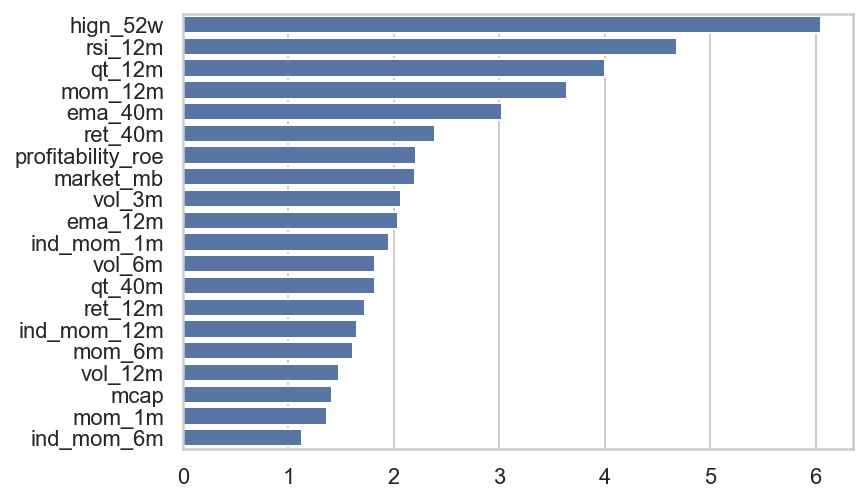

In [9]:
xgb_reg = XGBRegressor(n_estimators=10, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")
importance = pd.Series(data=xgb_reg.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")

In [10]:
data=pd.read_parquet("../data/backtest-beta.1.parquet")

Short positon sharpe ratio: 1.2966483193481926
Neutral positon sharpe ratio: 1.5690260461778271
Long positon sharpe ratio: 0.44213641303315365


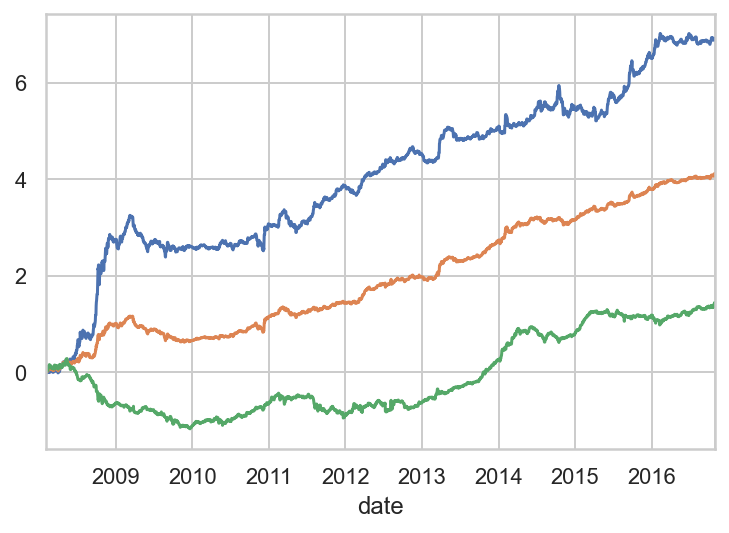

In [11]:
backtest_report(
    data,
    features,
    xgb_reg,
    test_start="2008-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")

## Classification

In [12]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2010-01-01",
    test_start="2010-01-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.62      0.57      0.59     20357
           0       0.78      0.01      0.01      4132
           1       0.59      0.74      0.65     22018

    accuracy                           0.60     46507
   macro avg       0.66      0.44      0.42     46507
weighted avg       0.62      0.60      0.57     46507

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.21      0.46      0.29     12897
           0       0.73      0.00      0.00     51400
           1       0.21      0.69      0.33     16236

    accuracy                           0.21     80533
   macro avg       0.38      0.38      0.21     80533
weighted avg       0.54      0.21      0.11     80533



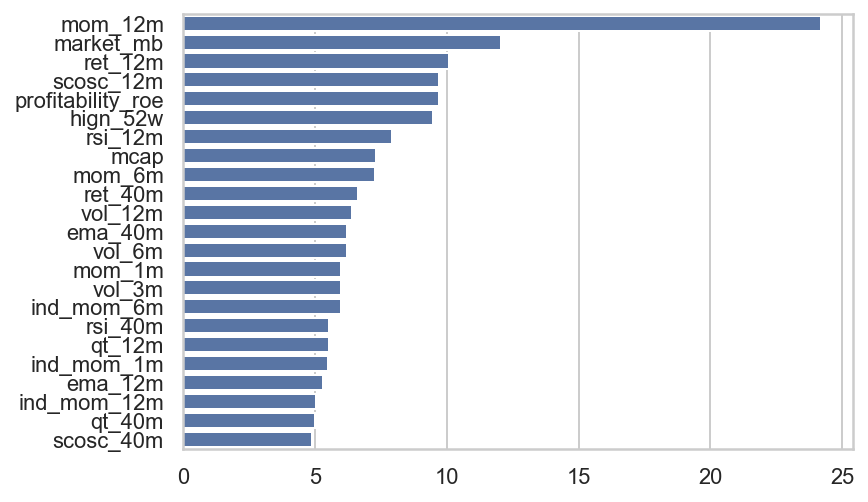

In [13]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short positon sharpe ratio: 0.9389829714024835
Neutral positon sharpe ratio: 1.5912558411328956
Long positon sharpe ratio: 0.8005815611956106


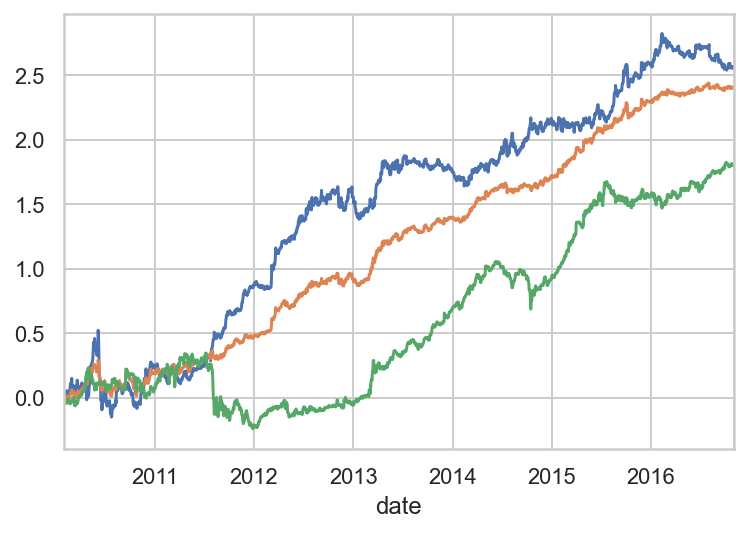

In [14]:
backtest_report(
    data,
    features,
    xgb_clf,
    test_start="2010-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")